### Import Required Libraries

In [ ]:
import networkx as nx
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix, csc_matrix, hstack, vstack, find as sparse_find, issparse
import community as community_louvain
import matplotlib.pyplot as plt
from community.community_louvain import best_partition
from sklearn.linear_model import LogisticRegression
import time
import warnings
from sklearn.exceptions import ConvergenceWarning
import os
from sklearn.decomposition import NMF
from sklearn.cluster import SpectralClustering
import scipy.sparse.linalg as splinalg
import random
from collections import defaultdict, deque
from sklearn.svm import LinearSVC
from sklearn.metrics import hinge_loss
import scipy.sparse as sp
from networkx.algorithms.community import kernighan_lin_bisection
from sklearn.linear_model import SGDClassifier
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


DataLoader: The function to load data.<br>
input: filepath (string)<br>
output: X and Y data in the shape of (csr_matrix n_samples x n_features) and (csr_matrix n_samples x n_labels) respectively

In [ ]:
class DataLoader:

    def load_multilabel_data(self, filepath):

        if not os.path.exists(filepath):
            print(f"Error: Data file not found at {filepath}")
            return None, None

        try:
            with open(filepath, 'r') as f:
                first_line = f.readline().split()
                if len(first_line) < 3:
                    raise ValueError("Invalid header format in data file.")
                n_samples = int(first_line[0])
                n_features = int(first_line[1])
                n_labels = int(first_line[2])

                if n_samples <= 0 or n_features <= 0 or n_labels <= 0:
                    raise ValueError("Invalid dimensions in header.")

                X_lil = lil_matrix((n_samples, n_features), dtype=np.float64)
                Y_lil = lil_matrix((n_samples, n_labels), dtype=np.int8)

                for i, line in enumerate(f):
                    if i >= n_samples:
                        print(f"Warning: More lines than expected ({n_samples}) in data file. Stopping.")
                        break

                    parts = line.strip().split(' ', 1)
                    if ':' in parts[0]:
                        labels_str = ""
                        features_str = parts[0] + " " + parts[1]
                    else:
                        labels_str = parts[0]
                        features_str = parts[1] if len(parts) > 1 else ''

                    if labels_str:
                        try:
                            label_indices = [int(l) for l in labels_str.split(',')]
                            for label_idx in label_indices:
                                if 0 <= label_idx < n_labels:
                                    Y_lil[i, label_idx] = 1
                                else:
                                    print(f"Warning: Label index {label_idx} out of bounds [0, {n_labels-1}) in line {i+2}. Skipping.")
                        except ValueError:
                            print(f"Warning: Skipping incorrect label string '{labels_str}' in line {i+2}")

                    if features_str:
                        for feature_pair in features_str.split(' '):
                            try:
                                idx_str, val_str = feature_pair.split(':')
                                feature_idx = int(idx_str)
                                feature_val = float(val_str)
                                if 0 <= feature_idx < n_features:
                                    X_lil[i, feature_idx] = feature_val
                                else:
                                    print(f"Warning: Feature index {feature_idx} out of bounds [0, {n_features-1}) in line {i+2}. Skipping.")
                            except ValueError:
                                print(f"Warning: Skipping incorrect feature pair '{feature_pair}' in line {i+2}")
                                continue

            X_csr = X_lil.tocsr()
            Y_csr = Y_lil.tocsr()
            print(f"Loaded data: X shape {X_csr.shape}, Y shape {Y_csr.shape}")
            print(f"X sparsity: {X_csr.nnz / (X_csr.shape[0] * X_csr.shape[1]):.4f}")
            print(f"Y sparsity: {Y_csr.nnz / (Y_csr.shape[0] * Y_csr.shape[1]):.4f}")
            return X_csr, Y_csr

        except Exception as e:
            print(f"Error loading data from {filepath}: {e}")
            return None, None



### Loading the datasets using the dataloader defined above

In [ ]:
data_filepath_train = '/content/drive/MyDrive/AIP_Proj/eurlex_train.txt'
data_filepath_test = '/content/drive/MyDrive/AIP_Proj/eurlex_test.txt'
data_loader = DataLoader()
X_train, Y_train = data_loader.load_multilabel_data(
    data_filepath_train
)
X_test, Y_test = data_loader.load_multilabel_data(
    data_filepath_test
)

Loaded data: X shape (15539, 5000), Y shape (15539, 3993)
X sparsity: 0.0474
Y sparsity: 0.0013
Loaded data: X shape (3809, 5000), Y shape (3809, 3993)
X sparsity: 0.0474
Y sparsity: 0.0013


### Importing the required modules for the implementation of autoencoder

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
X = np.concatenate((X_train.toarray(), X_train.toarray()), axis=0)

In [ ]:
X = (X - X.mean(axis=0)) / X.std(axis=0)
X_tensor = torch.tensor(X, dtype=torch.float32)

# Create DataLoader
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

### Auto encoder used to reduce the dimensionality of the X data

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim=5000, encoding_dim=1024):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 4096),
            nn.ReLU(),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Linear(2048, encoding_dim),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 2048),
            nn.ReLU(),
            nn.Linear(2048, 4096),
            nn.ReLU(),
            nn.Linear(4096, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

### Training the autoencoder to reduce the dimensionality of the X data

In [ ]:
model = Autoencoder().to('cuda')
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100

for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
        x_batch = batch[0]
        optimizer.zero_grad()
        x_batch = x_batch.to('cuda')
        output = model(x_batch)
        loss = criterion(output, x_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 473.1158
Epoch 2, Loss: 465.6703
Epoch 3, Loss: 460.7638
Epoch 4, Loss: 457.6201
Epoch 5, Loss: 455.4269
Epoch 6, Loss: 453.8725
Epoch 7, Loss: 453.1911
Epoch 8, Loss: 452.3987
Epoch 9, Loss: 451.8408
Epoch 10, Loss: 451.1700
Epoch 11, Loss: 451.0731
Epoch 12, Loss: 451.3474
Epoch 13, Loss: 451.3717
Epoch 14, Loss: 450.9935
Epoch 15, Loss: 451.4126
Epoch 16, Loss: 451.5683
Epoch 17, Loss: 451.7973
Epoch 18, Loss: 452.1941
Epoch 19, Loss: 452.7910
Epoch 20, Loss: 453.2645
Epoch 21, Loss: 453.0207
Epoch 22, Loss: 454.8687
Epoch 23, Loss: 454.0519
Epoch 24, Loss: 454.6797
Epoch 25, Loss: 455.8830
Epoch 26, Loss: 455.5381
Epoch 27, Loss: 456.5379
Epoch 28, Loss: 456.4388
Epoch 29, Loss: 456.7348
Epoch 30, Loss: 458.4318
Epoch 31, Loss: 457.8448
Epoch 32, Loss: 458.0660
Epoch 33, Loss: 457.8076
Epoch 34, Loss: 458.4387
Epoch 35, Loss: 459.1865
Epoch 36, Loss: 459.5130
Epoch 37, Loss: 460.2626
Epoch 38, Loss: 459.8449
Epoch 39, Loss: 461.0644
Epoch 40, Loss: 461.5351
Epoch 41,

### Training the autoencoder to reduce the dimensionality of the X data

In [ ]:
with torch.no_grad():
    X_train_reduce = model.encoder(torch.tensor(X_train.toarray(), dtype=torch.float32).to('cuda')).cpu().numpy()
    X_test_reduce = model.encoder(torch.tensor(X_test.toarray(), dtype=torch.float32).to('cuda')).cpu().numpy()

In [ ]:
X_train = csr_matrix(X_train_reduce)
X_test = csr_matrix(X_test_reduce)

In [ ]:
Y_train_T = Y_train.T

Function to partition the co-occurance matrix hierarchically. <br>
Input : Y matrix, depth which is used for partitioning <br>
output : permutation of the labels and partitioned indices

In [ ]:
def hierarchical_partition(Y, depth=3):
    A = Y @ Y.T
    G = nx.from_scipy_sparse_array(sp.csr_matrix(A))

    def recursive_partition(G, depth):
        if depth == 0 or G.number_of_nodes() <= 1:
            return [list(G.nodes)]
        try:
            part1, part2 = kernighan_lin_bisection(G)
        except:
            return [list(G.nodes)]
        G1 = G.subgraph(part1)
        G2 = G.subgraph(part2)
        return recursive_partition(G1, depth - 1) + recursive_partition(G2, depth - 1)

    partitions = recursive_partition(G, depth)
    permutation = [node for group in partitions for node in group]

    return permutation, partitions

In [ ]:
result = hierarchical_partition(Y_train_T)

In [ ]:
permutation = result[0]
partition = result[1]

### Applying the permutations to the Y matrix

In [ ]:
Y_train = Y_train.transpose().astype(np.int32)
Y_test = Y_test.transpose().astype(np.int32)
cooccurrence = (Y_train @ Y_train.T).toarray()
cooccurrence = cooccurrence[permutation][:, permutation]
Y_train_perm = Y_train[permutation]
Y_test_perm = Y_test[permutation]

In [ ]:
set_list = partition.copy()

### Partitioning the Y matrix based on the partition as per the hierarchical partitioning

In [ ]:
num_partitions = len(set_list)

Yp = []
Ytp = []
for i in range(num_partitions):
    Yp.append(Y_train_perm[set_list[i],:])
    Ytp.append(Y_test_perm[set_list[i],:])
    print(len(set_list[i]))

499
499
499
499
499
499
499
500


In [ ]:
K_EVAL = 5

### A simple predictor for cases where all labels in a group are constant.

In [ ]:
class ConstantPredictor:
    def __init__(self, value):
        if value not in [0, 1]:
            raise ValueError("Constant value must be 0 or 1")
        self.value = int(value)

    def predict(self, X):
        return np.full(X.shape[0], self.value, dtype=np.int8)

    def predict_proba(self, X):
        n_samples = X.shape[0]
        proba = np.zeros((n_samples, 2), dtype=float)
        proba[:, self.value] = 1.0
        return proba

    def fit(self, X, y):
        pass

### NMFGT class, which will train the NMFGT model by creating the GT matrix and training many intermediate classifiers.

In [ ]:
class NMFGTModel:
    def __init__(self, n_groups, k_target_sparsity=K_EVAL, column_sparsity_range=None,
                nmf_options=None, classifier_options=None, random_state=42):
        """
        Constructor method to initialize the NMFGTModel.

        Args:
            n_groups (int): Number of groups (m), the target dimension for reduction
            k_target_sparsity (int): Target label sparsity for evaluation and c selection
            column_sparsity_range (list or range): Range of column sparsity values (c) to test
            nmf_options (dict, optional): Options for scikit-learn's NMF
            classifier_options (dict, optional): Options for scikit-learn's LogisticRegression
            random_state (int): Random seed for reproducing results
        """
        self.n_groups = n_groups
        self.k_target_sparsity = k_target_sparsity
        self.column_sparsity_range = column_sparsity_range if column_sparsity_range is not None else list(range(10, 71, 10))
        self.random_state = random_state
        np.random.seed(random_state)

        self.nmf_options = {
            'init': 'nndsvda', 'max_iter': 1500, 'tol': 1e-4,
            'solver': 'cd', 'beta_loss': 'frobenius', 'random_state': random_state,
            'n_components': self.n_groups
        }

        if nmf_options:
            self.nmf_options.update(nmf_options)
            self.nmf_options['n_components'] = self.n_groups

        self.classifier_options = {
            'penalty':'l2',
            'loss':'squared_hinge',
            'max_iter':1000,
            'dual':True,
            'C':1.0,
            'random_state':random_state
        }

        if classifier_options:
            self.classifier_options.update(classifier_options)
            self.classifier_options['random_state'] = random_state

        self.gt_matrix_ = None
        self.selected_column_sparsity_ = None
        self.nmf_reconstruction_error_ = None
        self.selection_hamming_loss_ = None
        self.classifiers_ = None
        self.train_time_ = None

    def _reweight_proba_vector(self, P_initial, column_sparsity):
        """Reweights a probability vector."""

        n = len(P_initial)
        Pi_weighted = column_sparsity * np.array(P_initial)
        id1_mask = Pi_weighted >= 1

        if np.sum(id1_mask) >= column_sparsity:
            Pi_weighted[id1_mask] = 1
            return Pi_weighted

        id2_sorted_indices = np.argsort(Pi_weighted)[::-1]
        tmp = Pi_weighted[id2_sorted_indices]

        exc = 0.0
        for j in range(n):
            if tmp[j] >= 1.0:
                exc += (tmp[j] - 1.0)
                tmp[j] = 1.0
            elif exc > 1e-9:
                sum_remaining = np.sum(tmp[j:])
                if sum_remaining > 1e-9:
                    factor = 1.0 + exc / sum_remaining
                    tmp[j:] *= factor
                    exc = 0.0
                else:
                    remaining_count = n - j
                    if remaining_count > 0:
                        add_val = exc / remaining_count
                        tmp[j:] += add_val
                        exc = 0.0
                became_one_mask = tmp[j:] >= 1.0
                if np.any(became_one_mask):
                    exc += np.sum(tmp[j:][became_one_mask] - 1.0)
                    tmp[j:][became_one_mask] = 1.0

            if np.sum(tmp >= 1.0) >= column_sparsity or exc < 1e-9:
                Pi_final = np.zeros_like(Pi_weighted)
                Pi_final[id2_sorted_indices] = tmp
                Pi_final[Pi_final < 0] = 0
                return Pi_final

        Pi_final = np.zeros_like(Pi_weighted)
        Pi_final[id2_sorted_indices] = tmp
        Pi_final[Pi_final < 0] = 0
        return Pi_final

    def _build_sparse_rand_vector(self, P_initial, column_sparsity):
        """Generates a sparse random vector based on probabilities."""
        n = len(P_initial)
        P_reweighted = self._reweight_proba_vector(P_initial, column_sparsity)
        vec = np.zeros(n, dtype=np.int8)
        rand_nums = np.random.rand(n)
        vec[P_reweighted >= 1.0] = 1
        sample_mask = (P_reweighted < 1.0) & (P_reweighted > 0)
        vec[sample_mask] = (rand_nums[sample_mask] < P_reweighted[sample_mask]).astype(np.int8)
        return csr_matrix(vec).T

    def _build_gt_matrix(self, H_basis, column_sparsity):
        """Generates the full GT matrix A."""
        d, m = H_basis.shape # H_basis --> (d x m)
        if m != self.n_groups:
            print(f"Warning: NMF basis dimension ({m}) differs from n_groups ({self.n_groups}). Using {m}.")
        A_cols = []
        print(f"Generating GT matrix A ({m} x {d}) with target column sparsity c={column_sparsity}...")
        for i in range(d):
            H_row_i = H_basis[i, :]
            sum_H_row_i = np.sum(H_row_i)
            if sum_H_row_i > 1e-9:
                P_initial = H_row_i / sum_H_row_i
            else:
                P_initial = np.ones(m) / m
            A_col_i = self._build_sparse_rand_vector(P_initial, column_sparsity)
            A_cols.append(A_col_i)

            if (i + 1) % 50 == 0 or (i + 1) == d:
                print(f"Generated GT column {i+1}/{d}")

        A = hstack(A_cols, format='csc')
        print(f"Generated GT matrix A: shape {A.shape}, nnz {A.nnz}, avg col sparsity {A.nnz / d:.2f}")
        return A

    def _build_A(self, Y_train_csc):
        """
        Performs NMF, selects best 'c', and generates the GT matrix A.
        """
        d, n_train = Y_train_csc.shape
        print(f"\nSelecting best column sparsity 'c' from {self.column_sparsity_range}...")
        print("Calculating YYT (may take time)...")

        start_yyt = time.time()
        try:
            YYT = Y_train_csc @ Y_train_csc.T   # (d x d)
        except Exception as e:
            print(f"Error calculating YYT: {e}.")
            return None, None, None
        end_yyt = time.time()

        print(f"YYT calculation took {end_yyt - start_yyt:.2f}s. Shape: {YYT.shape}")

        if issparse(YYT):
            neg_indices = YYT < 0
            if neg_indices.nnz > 0:
                print(f"Warning: Found {neg_indices.nnz} negative values in sparse YYT. Clamping to 0.")
                YYT[neg_indices] = 0
        else:
            YYT[YYT < 0] = 0


        print(f"Performing NMF on YY^T (n_components={self.n_groups})...")
        start_nmf = time.time()
        nmf_model = NMF(**self.nmf_options)
        try:
            H_basis = nmf_model.fit_transform(YYT)
            self.nmf_reconstruction_error_ = nmf_model.reconstruction_err_

        except TypeError:
            print("NMF requires dense input, converting clamped YYT...")
            if YYT.nnz > 500e6:
                print("Warning: YYT is very large")
            YYT_dense = YYT.toarray()

            H_basis = nmf_model.fit_transform(YYT_dense)
            self.nmf_reconstruction_error_ = nmf_model.reconstruction_err_
            del YYT_dense

        except ValueError as ve:
            if "Negative values in data passed" in str(ve):
                print("Error: Negative values persist even after clamping. Check YYT calculation or NMF internal steps.")
            else:
                print(f"ValueError during NMF: {ve}")
            del YYT
            return None, None, None

        except Exception as e:
            print(f"Error during NMF: {e}")
            del YYT
            return None, None, None

        end_nmf = time.time()
        print(f"NMF completed in {end_nmf - start_nmf:.2f}s. Basis shape: {H_basis.shape}, Rec. Error: {self.nmf_reconstruction_error_:.4f}")
        del YYT

        min_avg_hamming_loss = float('inf')
        best_c = -1
        generated_matrices = {}

        n_eval = min(n_train, 500)
        Y_eval_csc = Y_train_csc[:, :n_eval]

        for c_val in self.column_sparsity_range:
            print(f"\n  Testing c = {c_val}...")
            A_candidate = self._build_gt_matrix(H_basis, c_val) # m x d
            if A_candidate is None:
                continue

            # We evaluate Hamming Loss on subset Y_eval_csc (d x n_eval)
            Z_reduced_eval = (A_candidate @ Y_eval_csc > 0).astype(np.int8) # m x n_eval
            Scores_rec_eval = A_candidate.T @ Z_reduced_eval # d x n_eval

            total_hamming_dist = 0
            for l in range(n_eval):
                scores_l = Scores_rec_eval[:, l].toarray().ravel()
                y_true_l = Y_eval_csc[:, l].toarray().ravel()
                k_actual = int(max(1, np.sum(y_true_l)))
                k_predict = min(k_actual, self.k_target_sparsity)

                if len(scores_l) == 0 or np.all(scores_l == scores_l[0]):
                    top_k_indices = np.random.choice(d, size=min(k_predict, d), replace=False)
                else:
                    top_k_indices = np.argsort(scores_l)[::-1][:k_predict]

                y_pred_l = np.zeros(d, dtype=np.int8)
                if len(top_k_indices) > 0:
                    y_pred_l[top_k_indices] = 1
                total_hamming_dist += np.sum(y_pred_l != y_true_l)

            avg_hamming_loss = total_hamming_dist / (n_eval * d)
            generated_matrices[c_val] = A_candidate
            print(f"Avg Hamming Loss (on {n_eval} samples): {avg_hamming_loss:.6f}")

            if avg_hamming_loss < min_avg_hamming_loss:
                min_avg_hamming_loss = avg_hamming_loss
                best_c = c_val

        if best_c == -1 and generated_matrices:
            best_c = self.column_sparsity_range[0]
            min_avg_hamming_loss = np.inf

        print(f"\nSelected c = {best_c} with min Hamming Loss = {min_avg_hamming_loss:.6f}")
        best_A = generated_matrices.get(best_c)
        if best_A is None:
            print("Error: Could not retrieve the generated GT matrix for the best c")
            return None, None, None

        self.selection_hamming_loss_ = min_avg_hamming_loss
        return best_A, best_c, min_avg_hamming_loss

    def fit(self, X_train, Y_train):
        """
        Trains the NMF-GT model.
        """

        print("\n--- Starting NMF-GT Model Training ---")
        start_fit_time = time.time()
        n_samples, n_features = X_train.shape
        d = Y_train.shape[1]

        if Y_train.shape[0] != n_samples:
            raise ValueError("X_train and Y_train must have the same number of samples.")

        Y_train_csc_T = Y_train.T.tocsc()
        best_A, best_c, _ = self._build_A(Y_train_csc_T)
        return best_A

### Initialization of the variables for the NMFGT model

In [ ]:
n_groups_m = 350
k_target = 5
c_range = list(range(5, 96, 5))
RANDOM_SEED = 42

### Calculating the Grouping matrix for each partition and trains a simple linear model for each partition

In [ ]:
start_clf_time = time.time()
SVMs= []
A1s = []
for i in range(num_partitions):
    Y1 = Yp[i]
    Y1 = Y1.transpose()
    X1 = X_train
    nmfgt_model = NMFGTModel(
        n_groups=n_groups_m,
        k_target_sparsity=k_target,
        column_sparsity_range=c_range,
        random_state=RANDOM_SEED
    )
    A1 = nmfgt_model.fit(X1, Y1)
    A1s.append(A1)
    Z = (A1 @ Y1.T > 0).astype(int)
    SVM = []
    m=Z.shape[0]
    Z = Z.toarray()
    X1 = X1.toarray()
    for j in range(m):
        y2 = Z[j, :]
        clf = SGDClassifier(loss='log_loss')  # Equivalent to linear SVM
        clf.fit(X1, y2)
        SVM.append(clf)
        elapsed_time = time.time() - start_clf_time
        print(f"Trained classifier {j+1}/{m} ({elapsed_time:.1f}s elapsed)")
    SVMs.append(SVM)

Streaming output truncated to the last 5000 lines.
Generating GT matrix A (350 x 499) with target column sparsity c=55...
Generated GT column 50/499
Generated GT column 100/499
Generated GT column 150/499
Generated GT column 200/499
Generated GT column 250/499
Generated GT column 300/499
Generated GT column 350/499
Generated GT column 400/499
Generated GT column 450/499
Generated GT column 499/499
Generated GT matrix A: shape (350, 499), nnz 27543, avg col sparsity 55.20
Avg Hamming Loss (on 500 samples): 0.001082

  Testing c = 60...
Generating GT matrix A (350 x 499) with target column sparsity c=60...
Generated GT column 50/499
Generated GT column 100/499
Generated GT column 150/499
Generated GT column 200/499
Generated GT column 250/499
Generated GT column 300/499
Generated GT column 350/499
Generated GT column 400/499
Generated GT column 450/499
Generated GT column 499/499
Generated GT matrix A: shape (350, 499), nnz 29973, avg col sparsity 60.07
Avg Hamming Loss (on 500 samples):

### Calculate the Z's for the X_test and convert them back to the Y matrix

In [ ]:
ATp = csr_matrix((Y_train.shape[0], X_test.shape[0]))
for i in range(num_partitions):
    Ztest = csr_matrix((n_groups_m, X_test.shape[0]))
    print(i)
    for j in range(m):
        z_pred = SVMs[i][j].predict(X_test)
        Ztest[j,:] = z_pred.T
    test_scores=A1s[i].T@Ztest
    tmp_ATp = csr_matrix((Y_train.shape[0], X_test.shape[0]))
    tmp_ATp[set_list[i],:] =  test_scores
    ATp = ATp + tmp_ATp

### Calculate the modified precision @ K problem

In [ ]:
def precision_k_new(score_mat, true_mat, K):
    return helper(score_mat, true_mat, K)

def helper(score_mat, true_mat, K):
    num_lbl, num_inst = score_mat.shape
    P = np.zeros(K)

    rank_mat = sort_sparse_mat(score_mat)

    mat = []
    for j in range(num_inst):
        tmp = rank_mat[:, j].copy()
        tmp[tmp > K] = 0
        mat_col = (tmp > 0).astype(int)
        mat.append(mat_col)
    mat = np.stack(mat, axis=1)
    mat = csr_matrix(mat)

    mat = mat.multiply(true_mat)
    num = np.array(mat.sum(axis=0)).flatten()

    for k in range(1, K + 1):
        num2 = np.minimum(num, k)
        P[k - 1] = np.mean(num2 / k)

    return P

def sort_sparse_mat(score_mat):
    """
    For each column, return a matrix of ranks.
    Higher scores get lower rank numbers (1 = highest).
    """
    num_lbl, num_inst = score_mat.shape
    rank_mat = np.zeros((num_lbl, num_inst), dtype=int)

    score_mat = score_mat.toarray()

    for j in range(num_inst):
        scores = score_mat[:, j]
        order = np.argsort(-scores)
        ranks = np.empty_like(order)
        ranks[order] = np.arange(1, num_lbl + 1)
        rank_mat[:, j] = ranks

    return rank_mat


In [ ]:
P = precision_k_new(ATp, Y_test_perm, K_EVAL)

In [ ]:
print(P)

### Calculate the precision @ K problem

In [ ]:
def precision_k(score_mat, true_mat, K):
    return _helper(score_mat, true_mat, K)

def _helper(score_mat, true_mat, K):
    num_lbl, num_inst = score_mat.shape
    P = np.zeros(K)

    score_mat = csr_matrix(score_mat)

    rank_mat = sort_sparse_mat(score_mat)

    for k in range(1, K + 1):
        mat = rank_mat.copy()
        mat.data[mat.data > k] = 0
        mat.eliminate_zeros()

        mat.data = np.ones_like(mat.data)

        mat = mat.multiply(true_mat)

        num = np.array(mat.sum(axis=0)).flatten()

        P[k - 1] = np.mean(num / k)

    return P

def sort_sparse_mat(score_mat):
    """Returns a matrix where each column has rank values for non-zero elements."""
    score_mat = score_mat.tocsc()
    rank_mat = lil_matrix(score_mat.shape)

    for j in range(score_mat.shape[1]):
        col = score_mat[:, j].toarray().flatten()
        if np.count_nonzero(col) == 0:
            continue
        ranked_indices = np.argsort(-col)
        ranks = np.zeros_like(col)
        ranks[ranked_indices] = np.arange(1, len(col) + 1)
        ranks[col == 0] = 0
        rank_mat[:, j] = ranks.reshape(-1, 1)

    return rank_mat.tocsr()

In [ ]:
P_old = precision_k(ATp, Y_test_perm, K_EVAL)

In [ ]:
P_old

array([0.31688107, 0.25111578, 0.21029142, 0.17872145, 0.15715411])

In [1]:
import matplotlib.pyplot as plt
import numpy as np
ks = [1,2,3,4,5]

### Plotting the results

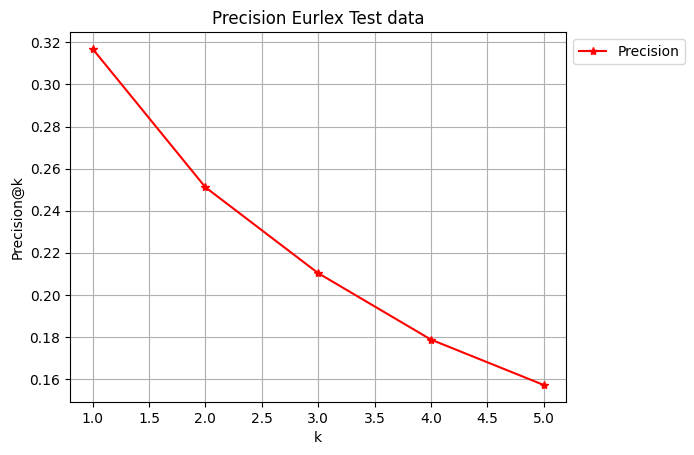

In [3]:
plt.plot(ks, P_old, 'r*-', label='Precision')

plt.title('Precision Eurlex Test data')
plt.ylabel('Precision@k')
plt.xlabel('k')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()